In [2]:
from os import listdir
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

In [3]:
pickel_dir_path = "YOUR_PATH\\data\\pickels_v2"
pickel_path = f"{pickel_dir_path}\\aggregated_car_data_2016.pkl"
data = pd.read_pickle(pickel_path)

In [4]:
smaller_col_count = ["lamId", "dayIndex", "year", "direction", "CarCount"]
lam1 = data[data["lamId"] == 998][smaller_col_count]
lam1_day32 = lam1[lam1["dayIndex"] == 32].reset_index()

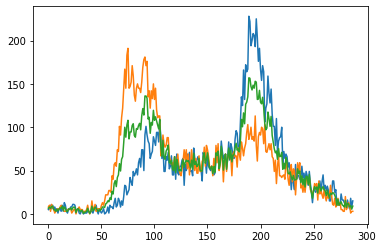

In [5]:
x = [i for i in range(288)]
plt.plot(x, lam1_day32.loc[0]["CarCount"])
plt.plot(x, lam1_day32.loc[1]["CarCount"])
plt.plot(x, lam1_day32["CarCount"].mean())

In [6]:
# THIS AINT WORKING CORRECTLY SO DONT USE IT...
def get_first_weekday_of_month(year, month, weekday):
  first_day = datetime(year, month, 1)
  first_weekday = first_day.weekday()
  day_of_week_delta = weekday - first_weekday  if first_weekday < weekday else 7 - weekday
  return (first_day.timetuple().tm_yday + day_of_week_delta % 7) - 1

def blur(data, blur_range):
  data_len = len(data)
  blurred = []
  for i in range(data_len):
    sum = 0
    count = 0
    for j in range(i-1, i+blur_range+1):
      if j < 0 or j > data_len-1:
        continue
      sum += data[j]
      count += 1
    weight = blur_range / 3
    sum += data[i]*weight
    blurred.append(sum / (count+weight))
  return blurred

In [7]:
day_names = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]

def plot_features_and_their_average(start_day_index, number_of_days, data, lam_id, weekday_index, smoothing=0):
  days = [start_day_index + x * 7 for x in range(number_of_days)]
  days_data = data[data["dayIndex"].isin(days)]

  lam_data = days_data[days_data["lamId"] == lam_id]
  dir1 = lam_data[lam_data["direction"] == 1]
  dir2 = lam_data[lam_data["direction"] == 2]
  dir1_m = dir1["CarCount"].mean()
  dir2_m = dir2["CarCount"].mean()
  both_m = lam_data["CarCount"].mean()

  mean = blur(both_m, smoothing)

  x = range(288)
  plt.plot(x, mean, label = "Mean", linewidth=3)
  plt.plot(x, dir1_m, label = "Mean", linewidth=1)
  plt.plot(x, dir2_m, label = "Mean", linewidth=1)
  for i in range(number_of_days):
    plt.plot(x, dir1.iloc[i]["CarCount"], label = f"Dir 1, Day {i+1}", linestyle=":", linewidth=1)
    plt.plot(x, dir2.iloc[i]["CarCount"], label = f"Dir 2, Day {i+1}", linestyle=":", linewidth=1)
  plt.legend()
  plt.title(f"LamId {lam_id}, {number_of_days} x {day_names[weekday_index]}{'s' if number_of_days > 1 else ''} with {smoothing}px smoothing on mean")

  plt.show()
  

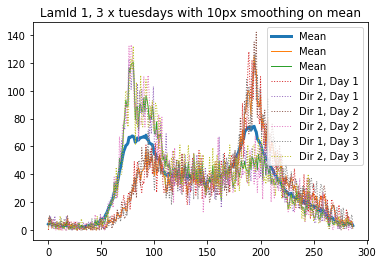

In [8]:
weekday_index = 1
start = get_first_weekday_of_month(2016, 2, weekday_index)
plot_features_and_their_average(start, 3, data, 1, weekday_index, 10)


In [9]:
def create_means_df(start_day_index, number_of_days, data, feature_name, smoothing=0):
  days = [start_day_index + x * 7 for x in range(number_of_days)]
  days_data = data[data["dayIndex"].isin(days)]
  data_with_all_days_present = days_data.groupby(["lamId"]).filter(lambda x: x["dayIndex"].count() == 2*number_of_days)
  dir1 = data_with_all_days_present[data_with_all_days_present["direction"] == 1]
  dir2 = data_with_all_days_present[data_with_all_days_present["direction"] == 2]
  grouped = data_with_all_days_present.groupby(["lamId"])
  grouped_dir1 = dir1.groupby(["lamId"])
  grouped_dir2 = dir2.groupby(["lamId"])
  dir1_m = grouped_dir1[feature_name].mean()
  dir2_m = grouped_dir2[feature_name].mean()
  both_m = grouped[feature_name].mean()
  mean = both_m.apply(lambda x: blur(x, smoothing))

  lam_ids = grouped["lamId"].min()
  day_indices = grouped["dayIndex"].min()

  result_data = {
    "lamIds": lam_ids,
    "day_indices": day_indices,
    "mean_both_directions": mean,
    "mean_dir_1": dir1_m,
    "mean_dir_2": dir2_m,
  }

  return pd.DataFrame(result_data)

In [10]:
start = get_first_weekday_of_month(2016, 2, weekday_index)
data_with_means = create_means_df(start, 3, data, "CarCount", 10)

In [11]:
data_with_means

,lamIds,day_indices,mean_both_directions,mean_dir_1,mean_dir_2
lamId,,,,,
1,1,32,"[4.205426356589147, 5.065217391304347, 4.78623...","[4.666666666666667, 9.333333333333334, 6.33333...","[3.0, 6.666666666666667, 7.0, 3.0, 3.333333333..."
99,99,32,"[9.713178294573643, 9.032608695652174, 8.47826...","[9.666666666666666, 7.666666666666667, 9.66666...","[15.666666666666666, 13.333333333333334, 10.33..."
102,102,32,"[4.426356589147287, 4.75, 4.634057971014492, 4...","[5.666666666666667, 6.0, 9.0, 7.33333333333333...","[3.0, 6.0, 2.3333333333333335, 8.6666666666666..."
103,103,32,"[7.1434108527131785, 7.278985507246377, 7.2028...","[7.666666666666667, 5.333333333333333, 12.0, 1...","[5.666666666666667, 10.333333333333334, 4.6666..."
104,104,32,"[5.135658914728682, 5.22463768115942, 5.003623...","[9.666666666666666, 8.666666666666666, 6.33333...","[2.0, 3.0, 4.0, 2.3333333333333335, 3.66666666..."
...,...,...,...,...,...
1603,1603,32,"[3.22093023255814, 3.3804347826086962, 2.42028...","[5.666666666666667, 8.0, 3.0, 3.33333333333333...","[3.3333333333333335, 2.0, 0.6666666666666666, ..."
1604,1604,32,"[3.8682170542635657, 3.4565217391304346, 2.847...","[6.333333333333333, 6.0, 4.666666666666667, 1....","[5.333333333333333, 3.0, 1.3333333333333333, 0..."
1605,1605,32,"[3.0426356589147288, 3.0905797101449277, 2.684...","[4.333333333333333, 4.0, 1.3333333333333333, 5...","[2.3333333333333335, 4.333333333333333, 3.6666..."


In [11]:
data_with_means.to_pickle(f"{pickel_dir_path}\\aggregated_car_data_2016_from_day_32_3_weeks_means.pkl")

In [12]:
for i in range(0, 7):
  start = get_first_weekday_of_month(2016, 2, i)
  data_with_means = create_means_df(start, 3, data, "CarCount", 10)
  data_with_means.to_pickle(f"{pickel_dir_path}\\aggregated_car_data_2016_from_day_{start}_3_weeks_means.pkl")

In [12]:
get_first_weekday_of_month(2022, 1, 4)

3

In [13]:
def get_first_weekday_of_month_v2(year, month, weekday):
  first_day = datetime(year, month, 1)
  first_weekday = first_day.weekday()
  time_delta = 0
  if weekday < first_weekday:
    time_delta = 7 - first_weekday + weekday
  elif weekday > first_weekday:
    time_delta = weekday - first_weekday

  return (first_day.timetuple().tm_yday + time_delta)

In [14]:
day_names = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]

for i in range(len(day_names)):
  print(f"First {day_names[i]} is {get_first_weekday_of_month_v2(2022, 2, i)}th day")

First monday is 38th day
First tuesday is 32th day
First wednesday is 33th day
First thursday is 34th day
First friday is 35th day
First saturday is 36th day
First sunday is 37th day


In [15]:
all_data_with_means = []

for i in range(0, 7):
  start = get_first_weekday_of_month_v2(2016, 2, i)
  dwm = create_means_df(start, 3, data, "CarCount", 10)
  dwm.to_pickle(f"{pickel_dir_path}\\aggregated_car_data_2016_from_day_{start}_3_weeks_means_10_smoothing.pkl")
  all_data_with_means.append(dwm)

In [16]:
week_df = pd.concat(all_data_with_means)

In [17]:
week_df

,lamIds,day_indices,mean_both_directions,mean_dir_1,mean_dir_2
lamId,,,,,
1,1,32,"[4.205426356589147, 5.065217391304347, 4.78623...","[4.666666666666667, 9.333333333333334, 6.33333...","[3.0, 6.666666666666667, 7.0, 3.0, 3.333333333..."
99,99,32,"[9.713178294573643, 9.032608695652174, 8.47826...","[9.666666666666666, 7.666666666666667, 9.66666...","[15.666666666666666, 13.333333333333334, 10.33..."
102,102,32,"[4.426356589147287, 4.75, 4.634057971014492, 4...","[5.666666666666667, 6.0, 9.0, 7.33333333333333...","[3.0, 6.0, 2.3333333333333335, 8.6666666666666..."
103,103,32,"[7.1434108527131785, 7.278985507246377, 7.2028...","[7.666666666666667, 5.333333333333333, 12.0, 1...","[5.666666666666667, 10.333333333333334, 4.6666..."
104,104,32,"[5.135658914728682, 5.22463768115942, 5.003623...","[9.666666666666666, 8.666666666666666, 6.33333...","[2.0, 3.0, 4.0, 2.3333333333333335, 3.66666666..."
...,...,...,...,...,...
1603,1603,38,"[7.244186046511627, 6.869565217391303, 6.74637...","[13.0, 11.333333333333334, 15.333333333333334,...","[4.0, 3.6666666666666665, 1.3333333333333333, ..."
1604,1604,38,"[7.186046511627906, 7.601449275362318, 6.63043...","[12.666666666666666, 15.333333333333334, 10.66...","[2.3333333333333335, 5.0, 2.3333333333333335, ..."
1605,1605,38,"[7.624031007751937, 6.583333333333334, 6.90217...","[14.666666666666666, 9.333333333333334, 13.666...","[5.0, 1.3333333333333333, 4.333333333333333, 3..."


In [18]:
week_df_grouped = week_df.groupby("lamIds")

In [19]:
week_df_filtered_not_full_weeks = week_df_grouped.filter(lambda x: x["day_indices"].count() == 7)


In [20]:
week_grouped = week_df_filtered_not_full_weeks.groupby("lamIds")

In [21]:
np.concatenate(week_grouped.get_group(1).sort_values("day_indices")["mean_dir_1"].values).shape

(2016,)

In [22]:
week_grouped.get_group(1).sort_values("day_indices")

,lamIds,day_indices,mean_both_directions,mean_dir_1,mean_dir_2
lamId,,,,,
1,1,32,"[4.205426356589147, 5.065217391304347, 4.78623...","[4.666666666666667, 9.333333333333334, 6.33333...","[3.0, 6.666666666666667, 7.0, 3.0, 3.333333333..."
1,1,33,"[3.596899224806202, 3.630434782608696, 3.43478...","[4.0, 8.333333333333334, 6.0, 2.33333333333333...","[5.333333333333333, 1.6666666666666667, 3.0, 0..."
1,1,34,"[3.1007751937984493, 2.6304347826086953, 2.039...","[8.333333333333334, 4.333333333333333, 1.33333...","[1.3333333333333333, 1.6666666666666667, 1.333..."
1,1,35,"[3.4573643410852717, 3.206521739130435, 3.0362...","[7.666666666666667, 4.0, 3.6666666666666665, 4...","[0.6666666666666666, 2.0, 1.6666666666666667, ..."
1,1,36,"[5.515503875968992, 4.2898550724637685, 3.7971...","[12.0, 7.333333333333333, 7.0, 5.0, 8.66666666...","[6.333333333333333, 1.3333333333333333, 0.3333..."
1,1,37,"[6.038759689922482, 6.105072463768116, 5.27898...","[7.333333333333333, 9.333333333333334, 4.66666...","[6.0, 5.333333333333333, 4.0, 4.66666666666666..."
1,1,38,"[6.364341085271317, 7.329710144927536, 6.75000...","[8.666666666666666, 11.666666666666666, 11.333...","[2.6666666666666665, 8.666666666666666, 3.6666..."


In [23]:
lam_ids = []
min_days = []
max_days = []
dir_1 = []
dir_2 = []
dir_mean = []

for g in week_grouped:
  sorted_data = g[1].sort_values("day_indices")
  dir_1_data = np.concatenate(sorted_data["mean_dir_1"].values)
  dir_2_data = np.concatenate(sorted_data["mean_dir_2"].values)
  both_dir_data = np.concatenate(sorted_data["mean_both_directions"].values)
  min_day = sorted_data["day_indices"].min()
  max_day = sorted_data["day_indices"].max()
  lam_ids.append(g[0])
  min_days.append(min_day)
  max_days.append(max_day)
  dir_1.append(dir_1_data)
  dir_2.append(dir_2_data)
  dir_mean.append(both_dir_data)

weekfied_data = pd.DataFrame({
  "lamId": lam_ids,
  "minDay": min_days,
  "maxDay": max_days,
  "dir_1":dir_1,
  "dir_2":dir_2,
  "dir_mean":dir_mean,
})

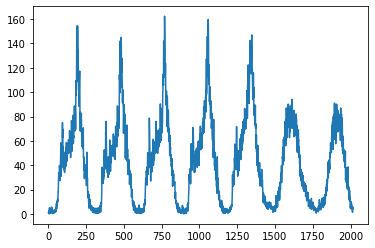

In [26]:
plt.plot(weekfied_data.iloc[195]["dir_2"])

In [27]:
weekfied_data.to_pickle(f"{pickel_dir_path}\\weekfied_car_data_2016_from_day_{32}_3_weeks_mean.pkl")

In [28]:
to_cluster_data = pd.DataFrame({
  "lamId": pd.concat([weekfied_data["lamId"], weekfied_data["lamId"]]), 
  "direction": [1 for i in range(len(weekfied_data))] + [2 for i in range(len(weekfied_data))],
  "data": pd.concat([weekfied_data["dir_1"], weekfied_data["dir_2"]])
})

In [29]:
from tslearn.utils import to_time_series_dataset
from tslearn.clustering import KShape
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

C:\Users\Mikko\anaconda3\envs\gradu\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [30]:
X_train = to_time_series_dataset(to_cluster_data["data"].values)
scaled = TimeSeriesScalerMeanVariance().fit_transform(X_train)

In [31]:
ks = KShape(6, random_state=1)
preds = ks.fit_predict(scaled)

In [32]:
preds

array([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 4, 2, 2, 2, 2, 0, 2, 2, 4, 2, 1, 0,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 4, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1,
       1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 0,
       0, 1, 2, 1, 2, 4, 2, 1, 2, 2, 1, 1, 2, 1, 1, 4, 2, 1, 0, 2, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 4, 2, 1, 2, 2, 1, 2, 2, 2, 1, 4,
       1, 3, 4, 4, 2, 2, 1, 2, 4, 2, 4, 1, 4, 1, 2, 2, 2, 2, 0, 2, 2, 1,
       2, 2, 4, 2, 4, 1, 2, 4, 1, 2, 1, 2, 2, 1, 2, 2, 4, 2, 2, 1, 2, 2,
       1, 4, 4, 4, 1, 4, 4, 4, 1, 2, 4, 4, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1,
       2, 2, 2, 2, 2, 4, 1, 4, 4, 1, 1, 2, 4, 1, 1, 4, 1, 3, 4, 1, 4, 4,
       2, 4, 4, 1, 4, 2, 4, 4, 1, 2, 1, 1, 4, 4, 4, 0, 2, 1, 1, 0, 4, 1,
       4, 2, 4, 4, 1, 4, 4, 1, 4, 0, 4, 2, 2, 1, 2, 2, 2, 2, 4, 2, 1, 1,
       1, 1, 4, 4, 4, 1, 4, 0, 4, 2, 2, 4, 2, 2, 4, 4, 1, 1, 1, 4, 1, 4,
       1, 3, 2, 4, 4, 1, 2, 4, 0, 2, 2, 4, 4, 2, 4, 4, 1, 2, 4, 1, 2, 2,
       1, 1, 2, 1, 2, 0, 1, 1, 5, 2, 1, 4, 4, 4, 4,

In [33]:
to_cluster_data["lamId"].values

array([   1,   99,  102,  104,  105,  106,  107,  108,  109,  110,  111,
        112,  114,  115,  117,  118,  119,  121,  122,  123,  124,  125,
        128,  130,  133,  134,  135,  136,  137,  138,  139,  140,  141,
        142,  144,  146,  147,  149,  150,  152,  153,  158,  159,  162,
        163,  164,  165,  167,  168,  169,  175,  176,  177,  178,  179,
        184,  185,  186,  187,  188,  189,  190,  191,  192,  193,  194,
        196,  197,  198,  201,  203,  204,  205,  206,  207,  208,  209,
        210,  211,  221,  223,  224,  225,  226,  227,  230,  232,  233,
        234,  235,  237,  238,  239,  240,  242,  243,  244,  245,  247,
        248,  249,  251,  252,  254,  255,  257,  303,  304,  305,  306,
        401,  402,  403,  404,  405,  406,  407,  408,  409,  421,  424,
        425,  426,  428,  429,  430,  431,  432,  433,  436,  437,  438,
        439,  441,  442,  443,  445,  446,  447,  448,  449,  450,  453,
        455,  456,  457,  458,  460,  461,  462,  4

In [34]:
ks2 = KShape(4, random_state=1)
preds2 = ks2.fit_predict(scaled)
preds2

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 0, 1, 0, 1, 2, 2, 2, 1, 1,
       1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 2, 1, 2, 0, 2, 1, 2, 2, 2, 0, 2, 2, 1, 0, 2, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0,
       1, 3, 0, 0, 2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 1,
       2, 2, 0, 2, 0, 1, 2, 0, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2, 1, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 1, 2, 0, 1, 1, 0, 0, 3, 3, 1, 0, 0,
       2, 0, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 0, 2, 1, 2, 0, 1, 1, 0, 1,
       0, 2, 2, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 2, 2, 2, 0, 2, 1, 0, 0, 1, 0,
       1, 3, 2, 0, 0, 2, 2, 0, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 2, 2,
       0, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 2, 0, 0, 0,

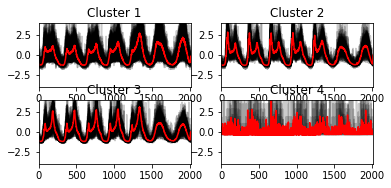

In [35]:
plt.figure()
for yi in range(4):
    plt.subplot(3, 2, 1 + yi)
    for xx in scaled[preds2 == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks2.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 2016)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

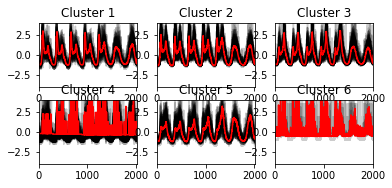

In [58]:
plt.figure()
for yi in range(6):
    plt.subplot(3, 3, 1 + yi)
    for xx in scaled[preds == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 2016)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

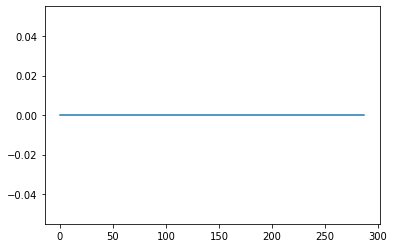

In [37]:
day = 6
plt.plot(to_cluster_data[to_cluster_data["lamId"] == 1438]["data"].values[0][day*288:(day+1)*288])

In [38]:
lam_id_list = to_cluster_data["lamId"].values
preds_to_analyse = preds2


In [39]:
class Pair:
  def __init__(self, first, second):
    self.first = first if first < second else second
    self.second = second if first < second else first

  def __eq__(self, other):
    condition1 = self.first == other.first and self.second == other.second
    condition2 = self.first == other.second and self.second == other.first
    return condition1 or condition2

  def __str__(self):
    return f"{self.first} - {self.second}"

  def __repr__(self):
    return self.__str__()

In [40]:
pairs = []
counts = []

for i in range(int(len(lam_id_list)/2)):
  new_pair = Pair(preds_to_analyse[i] + 1, preds_to_analyse[349+i] + 1)
  found = False
  for i in range(len(pairs)):
    if pairs[i] == new_pair:
      counts[i] += 1
      found = True
  if not found:
    # Add new pair
    pairs.append(new_pair)
    counts.append(1)    

In [41]:
counts

[195, 32, 90, 18, 3, 2, 3, 5, 1]

In [42]:
pairs

[2 - 3, 1 - 3, 1 - 1, 2 - 2, 1 - 2, 2 - 4, 4 - 4, 3 - 3, 3 - 4]

In [43]:
ks3 = KShape(6, random_state=1)
preds = ks3.fit_predict(X_train)

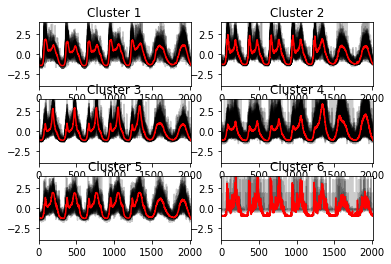

In [54]:
plt.figure()
for yi in range(6):
    plt.subplot(3, 2, 1 + yi)
    for xx in scaled[preds == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks3.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 2016)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

In [46]:
kmeans = TimeSeriesKMeans(6, random_state=1)
km_preds = kmeans.fit_predict(X_train)

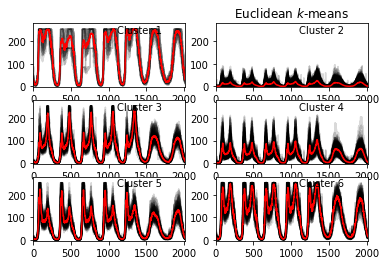

In [57]:
plt.figure()
for yi in range(6):
    plt.subplot(3, 2, yi + 1)
    for xx in X_train[km_preds == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.15)
    plt.plot(kmeans.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, 2016)
    plt.ylim(-4, 280)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

In [48]:
kms_pairs = []
kms_counts = []

for i in range(int(len(lam_id_list)/2)):
  new_pair = Pair(km_preds[i] + 1, km_preds[349+i] + 1)
  found = False
  for i in range(len(kms_pairs)):
    if kms_pairs[i] == new_pair:
      kms_counts[i] += 1
      found = True
  if not found:
    # Add new pair
    kms_pairs.append(new_pair)
    kms_counts.append(1)    

In [49]:
for i in range(len(kms_pairs)):
  print(f"{kms_counts[i]} x ({kms_pairs[i]})")

83 x (4 - 4)
47 x (3 - 5)
166 x (2 - 2)
24 x (6 - 6)
5 x (5 - 6)
9 x (1 - 1)
2 x (3 - 4)
4 x (2 - 4)
3 x (3 - 3)
2 x (2 - 5)
2 x (3 - 6)
2 x (4 - 5)


In [50]:
ks3.cluster_centers_[yi]

array([[-1.03310614],
       [-0.99148531],
       [-1.03310614],
       ...,
       [-1.03310614],
       [-1.03310614],
       [-1.03310614]])